# Kobe Bryant Shot Selection - Kaggle competition

In this notebook, I will present the work that I have realised for the "Kobe Bryant Shot Selection" competition:
https://www.kaggle.com/c/kobe-bryant-shot-selection, in which I finished 27th/1117.

## 1. Data and libraries imports

In [1]:
#Libraries import
import pandas as pd
import numpy as np
import math
import warnings
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

#Options setting
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
sns.set_color_codes()
warnings.filterwarnings('ignore')

In [2]:
#Data import 
data = pd.read_csv('data.csv')
print('Observations:', data.shape[0], '- Columns:', data.shape[1])

Observations: 30697 - Columns: 25


In [3]:
#First look
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


We have 30 697 shot observations and want to predict the shot_made_flag variable. It is a categorical feature that takes two values: 1 for a shot that went in and 0 otherwise. 5000 shot_made_flag values have been removed and those observations correspond to the test set that will be submitted in Kaggle.
<br>
To make our predictions, we have features corresponding to:
- The type of shot:
    - **action_type**: Detailled type of action that brought the shot,
    - **combined_shot_type**: General type of shot (Jump shot, Dunk, etc.),
    - **shot_type**: 2 or 3 Pointer.


- The shot time and localization:
    - **lat**: Latitude on the court from where the shot has been taken,
    - **lon**: Longitude on the court from where the shot has been taken,
    - **loc_x**: x-axis location on the court from where the shot was taken (between [-250, 250]),
    - **loc_y**: y-axis location on the court from where the shot was taken (between [-40, 900]),
    - **shot_distance**: Distance in meters from where the shot was taken,
    - **shot_zone_area**: Area of the shot (Left, Right, Center, etc.),
    - **shot_zone_basic**: Court zone of the shot (Paint, Restricted Area, Corner, etc.),
    - **shot_zone_range**: Range of shot distance,
    - **period**: Quarter in which the shot happened,
    - **minutes_remaining**: Number of minutes left before the quarter ends (integer between 0 and 11),
    - **seconds_remaining**: Seconds left before the end of the minute.
    
   
- The game:
    - **season**: NBA season,
    - **game_date**: Game date,
    - **playoffs**: 1 if the game was part of the season playoffs, 0 otherwise,
    - **team_id**: Team identifier of the shooter (Kobe Bryant),
    - **team_name**: Team name of the shooter (Kobe Bryant),
    - **opponent**: Abbreviation of opposing team,
    - **matchup**: String corresponding to the matchup (*'team_name vs. opponent'* for a home game or *'team_name @ opponent'* for an away game).
        
    
The three remaining variables ('game_event_id', 'game_id' and 'shot_id') are identifying variables. 
<br> <br>Kobe Bryant played all his career for the Los Angeles Lakers. So the features 'team_id' and 'team_name' will not be useful in the prediction, as they will never change. They both can be dropped.

In [4]:
data = data.drop(['team_id', 'team_name'], axis=1)

## 2. Data Analysis

Before building the model, we will analyse the different features that we have and their correlation to the target feature (*shot_made_flag*). It will allow us to find new insights and create new variables that will be useful to the predictions.

### 2.1. Target feature

In [5]:
data['shot_made_flag'].value_counts(dropna=False)

 0.0    14232
 1.0    11465
NaN      5000
Name: shot_made_flag, dtype: int64

As explained previously, the 5 000 missing values corresponds to the test set that needs to be submitted in Kaggle. <br>
We can see that the shot_made_flag variable is almost distributed equally (55,3% of missed shots and 44,7% of succesful shots). <br>
The dataset is well-balanced.

### 2.2. Type of shot

First, we will look at the type of shot, and see in which way it impacts the accuracy.

In [6]:
#Descriptive statistics
data[['action_type', 'combined_shot_type', 'shot_type']].describe()

,action_type,combined_shot_type,shot_type
count,30697,30697,30697
unique,57,6,2
top,Jump Shot,Jump Shot,2PT Field Goal
freq,18880,23485,24271


(0, 1)

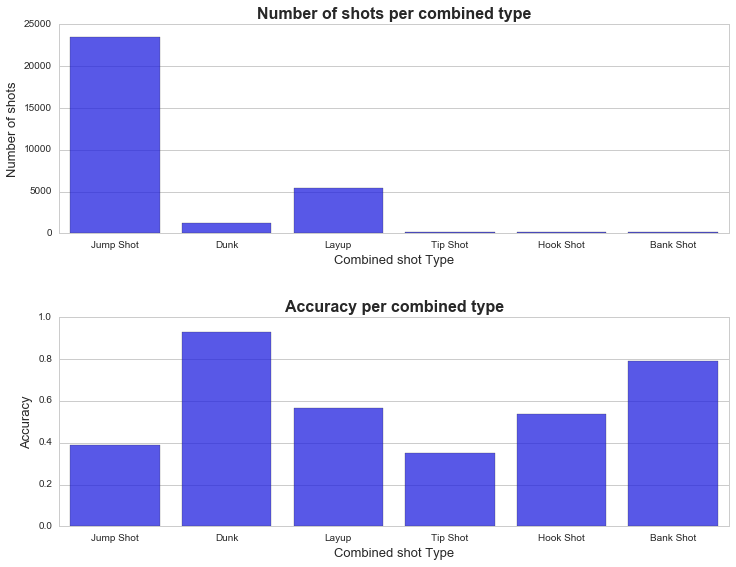

In [7]:
#Exploring the combined_shot_type feature
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
f.subplots_adjust(hspace=.4)

#Number of shots
sns.countplot(x='combined_shot_type', data=data, ax=ax1, color='blue', alpha=0.75)
ax1.set_title('Number of shots per combined type', fontsize=16, fontweight='bold')
ax1.set_xlabel('Combined shot Type', fontsize=13)
ax1.set_ylabel('Number of shots', fontsize=13)

#Accuracy
sns.barplot(x='combined_shot_type', y='shot_made_flag', data=data, ci=None, color='blue',
            alpha=0.75)
ax2.set_title('Accuracy per combined type', fontsize=16, fontweight='bold')
ax2.set_xlabel('Combined shot Type', fontsize=13)
ax2.set_ylabel('Accuracy', fontsize=13)
ax2.set_ylim(0, 1)

Through all his career, the vast majority of shots that Kobe took were jump shots (76%). He also performed 17% of lay-ups and dunks account for 4% of his shots.
<br>
We clearly observe on the second chart that the accuracy differs according to the type of shots. Indeed, if 40% of his jump shots fall in, the accuracy for lay-ups is 57% and it reaches a maximum value of 93% for dunks. <br>
In consequence, this feature will be very useful to determine if the shot has been made or not.

(0, 1)

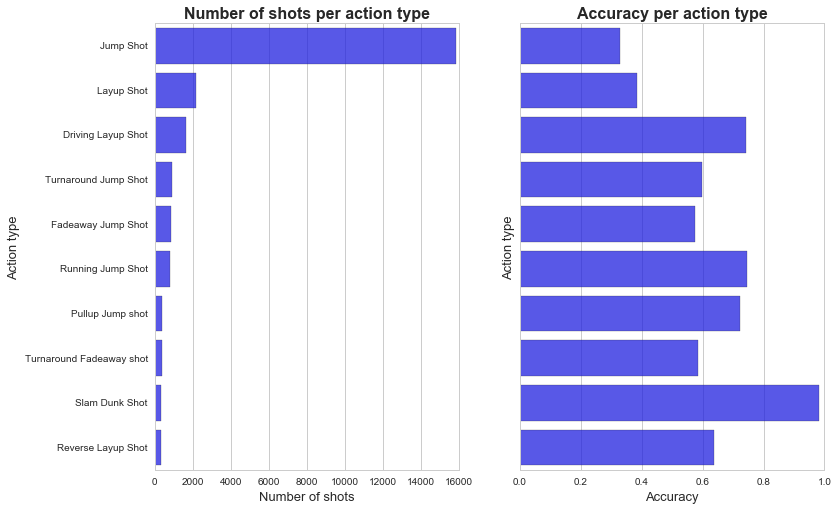

In [8]:
#Exploring the action_type feature (since we have 57 different value, 
#we will look at the 10 most represented)

#Computing accuracy and count per type of action
actionTypeStats = data.groupby('action_type', 
                               as_index=False)['shot_made_flag'].agg({'accuracy' : 'mean',
                                                                      'number' : 'count'})
actionTypeStats = actionTypeStats.sort_values('number', ascending=False).iloc[0:10,:]

#Plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

#Number of shots
sns.barplot(x='number', y='action_type', data=actionTypeStats, ci=None, ax=ax1, 
            color='blue', alpha = 0.75)
ax1.set_title('Number of shots per action type', fontsize=16, fontweight='bold')
ax1.set_xlabel('Number of shots', fontsize=13)
ax1.set_ylabel('Action type', fontsize=13)

#Accuracy
sns.barplot(x='accuracy', y='action_type', data=actionTypeStats, ci=None, ax=ax2, 
            color='blue', alpha=0.75)
ax2.set_title('Accuracy per action type', fontsize=16, fontweight='bold')
ax2.set_xlabel('Accuracy', fontsize=13)
ax2.set_ylabel('Action type', fontsize=13)
ax2.set_xlim(0, 1)

As seen previously, the most represented type of shots are jump shots, lay-ups and dunks. 
<br>
We can see that inside a general shot category, the accuracy varies greatly depending of the detailled type of shot. For example the accuracy for a running jump shots is 75% whereas it is 57% for fadeaway jump shots and only 32% for classic jump shots.

In [9]:
#Exploring the shot_type feature 
data.groupby('shot_type')['shot_made_flag'].agg({'accuracy' : 'mean', 'number' : 'count'})

,accuracy,number
shot_type,,
2PT Field Goal,0.477348,20285
3PT Field Goal,0.329268,5412


As we could expect, 2-points shots are more represented and also more succesful compared to 3-pointers, which are harder to make.

### Time of shot

Now, we will take a look at the time (in the game) at which the shot has been made, and its correlation with the accuracy.

In [10]:
#Adding the minute played in game according to period, minutes_remaining and seconds_remaining
data['minutes_in_game'] = np.where(data['period'] < 5, 
                                   data['period'] * 12 - data['minutes_remaining'] - 1,
                                   48 + 5 *(data['period'] - 4) - data['minutes_remaining'] - 1)

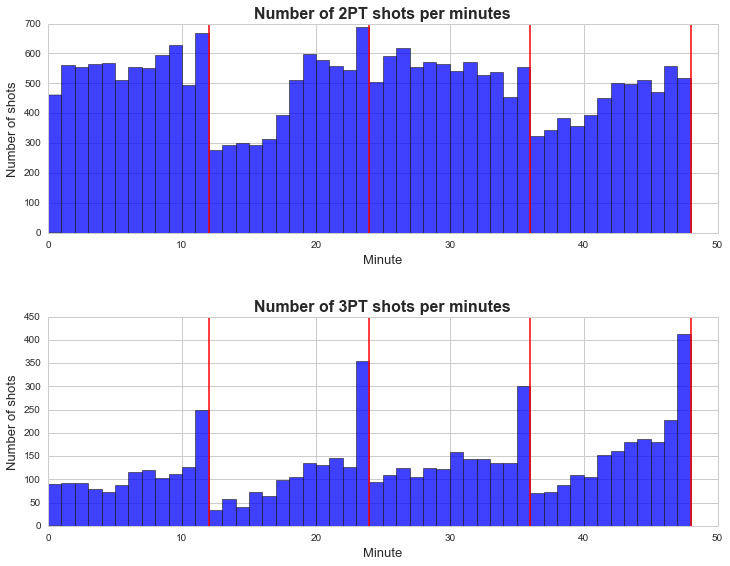

In [11]:
#Exploring the minute in game feature (Over Time excluded)

#Plots
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
f.subplots_adjust(hspace=.4)

#Histograms of shots according to the minute in game
#2pts shots
sns.distplot(data.query("period < 5 and shot_type == '2PT Field Goal'")['minutes_in_game'],
             color='blue', bins=list(range(0, 49)), kde=False, 
             hist_kws={'linewidth': 0.75, 'alpha': 0.75}, ax=ax1)
ax1.set_title('Number of 2PT shots per minutes', fontsize=16, fontweight='bold')
ax1.set_xlabel('Minute', fontsize=13)
ax1.set_ylabel('Number of shots', fontsize=13)
#Adding red lines at the end of each quarter
ax1.axvline(x=12, ymin=0, ymax=1000, color='red', linewidth=1.5)
ax1.axvline(x=24, ymin=0, ymax=1000, color='red', linewidth=1.5)
ax1.axvline(x=36, ymin=0, ymax=1000, color='red', linewidth=1.5)
ax1.axvline(x=48, ymin=0, ymax=1000, color='red', linewidth=1.5)

#3pts shots
sns.distplot(data.query("period < 5 and shot_type == '3PT Field Goal'")['minutes_in_game'],
             color='blue', bins = list(range(0,49)), kde=False, 
             hist_kws={'linewidth': 0.75, 'alpha': 0.75}, ax=ax2)
ax2.set_title('Number of 3PT shots per minutes', fontsize=16, fontweight='bold')
ax2.set_xlabel('Minute', fontsize=13)
ax2.set_ylabel('Number of shots', fontsize=13)
#Adding red lines at the end of each quarter
ax2.axvline(x=12, ymin=0, ymax=1000, color='red', linewidth=1.5)
ax2.axvline(x=24, ymin=0, ymax=1000, color='red', linewidth=1.5)
ax2.axvline(x=36, ymin=0, ymax=1000, color='red', linewidth=1.5)
ax2.axvline(x=48, ymin=0, ymax=1000, color='red', linewidth=1.5)

The number of 2-points shots is quite constant over each minutes. We notice that the number of shots taken during the first five minutes in 2nd and 4th quarter is lower. It is probably due to the fact that, as a frequent starter player, Kobe Bryant seats mostly in the bench during theses time periods.
<br> <br>
Concerning 3-points shots, we observe a spike in number in the last minute of each quarter and especially for the 4th. It shows that Kobe Bryant took more risks in the last minutes to score more points for his team.
<br> <br>
Let us see how it reflects on the accuracy.

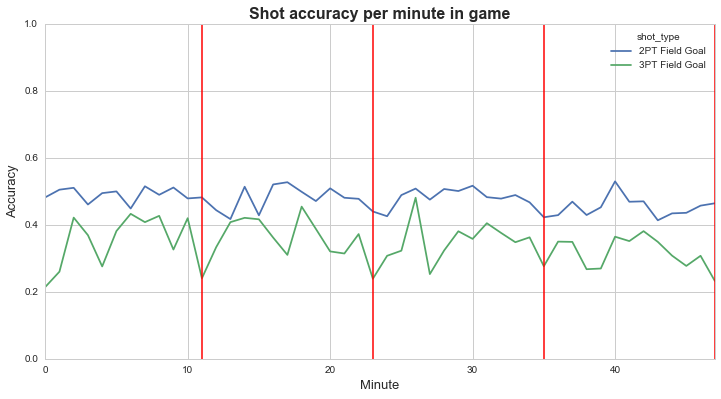

In [12]:
#Creating a new variable corresponding to the number of minutes that passed 
#since the beginning of the game
accuracyMinutes = data.query('period < 5').groupby(['minutes_in_game', 'shot_type']
                                                  )['shot_made_flag'].mean().unstack()
#Ploting accuracy for 2 and 3 pts shots per minutes
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
accuracyMinutes.plot(ax = ax)
ax.set_ylim(0, 1)
ax.set_title('Shot accuracy per minute in game', fontsize=16, fontweight='bold')
ax.set_xlabel('Minute', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.axvline(x=11, ymin=0, ymax=1, color='red', linewidth=1.5)
ax.axvline(x=23, ymin=0, ymax=1, color='red', linewidth=1.5)
ax.axvline(x=35, ymin=0, ymax=1, color='red', linewidth=1.5)
ax.axvline(x=47, ymin=0, ymax=1, color='red', linewidth=1.5)

We see that the accuracy is higher for 2-points shots than for 3 points. We also notice a dip in 3-points accuracy in the last minutes of each quarter. It seems to indicate that the shot attempted at theses minutes are more risky and have lower chance to go in. <br>
To take advantage of this fact in our model, a variable indicating if the shot was taken in the last minute of a quarter will be created.

In [13]:
#Creating the last_minute_shot variable
data["last_minute_shot"] = np.where(data['minutes_remaining'] == 0, 1, 0)

### 2.2 Shot localization

We will look at the localization on the court from which the shot has been made, and its correlation with the accuracy.

In [14]:
#Descriptive statistics for numerical features related to localization
data[['lat', 'lon', 'loc_x', 'loc_y', 'shot_distance']].describe()

,lat,lon,loc_x,loc_y,shot_distance
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,33.953192,-118.262690,7.110499,91.107535,13.437437
std,0.087791,0.110125,110.124578,87.791361,9.374189
min,33.253300,-118.519800,-250.000000,-44.000000,0.000000
25%,33.884300,-118.337800,-68.000000,4.000000,5.000000
50%,33.970300,-118.269800,0.000000,74.000000,15.000000
75%,34.040300,-118.174800,95.000000,160.000000,21.000000
max,34.088300,-118.021800,248.000000,791.000000,79.000000


In [15]:
#Descriptive statistics for categorical features related to localization
data[['shot_zone_area', 'shot_zone_basic', 'shot_zone_range']].describe()

,shot_zone_area,shot_zone_basic,shot_zone_range
count,30697,30697,30697
unique,6,7,5
top,Center(C),Mid-Range,Less Than 8 ft.
freq,13455,12625,9398


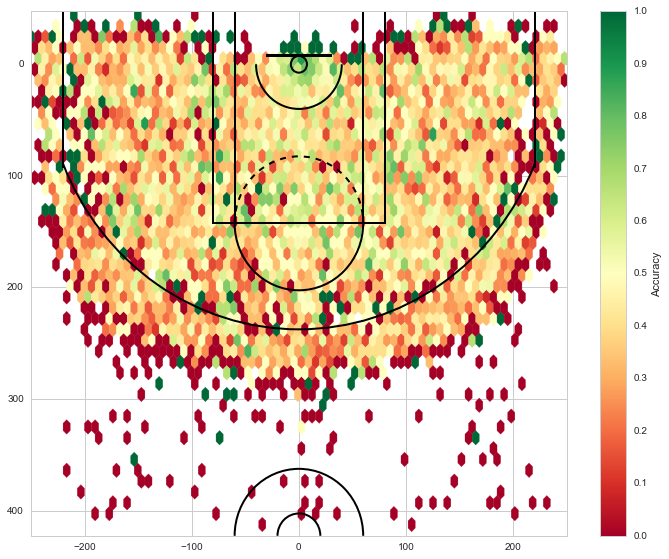

In [16]:
#Exploring the loc_x and loc_y features

# Function to draw a NBA court. 
# It has been developped by Savvas Tjortjoglou 
# (http://savvastjortjoglou.com/nba-shot-sharts.html)

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()
    # Create the various parts of an NBA basketball court
    
    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

#Ploting accuracy on the court with a 2D histogram
plt.figure(figsize=(12, 9.4))
plt.hexbin(data['loc_x'], data['loc_y'], C=data['shot_made_flag'], 
           cmap='RdYlGn', gridsize=75)
cb = plt.colorbar()
cb.set_label('Accuracy')
draw_court()
plt.xlim(-250,250)
plt.ylim(422.5, -47.5)
plt.show()

We can see that shots taken in the restricted area (semi circle underneath the basket) are very succesful. On the contrary the  shots attempted far below the 3-point line are almost always missed. Those shots are last seconds attempts that have almost no chance to get in.
<br>
It indicates that the distance from the basket is a important factor to determine if the shot has been made.

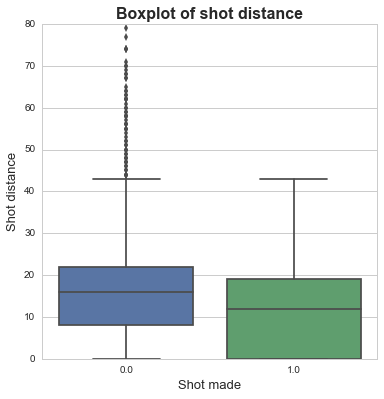

In [17]:
#Exploring the shot_distance feature
data['shot_made_flag_cat'] = data['shot_made_flag'].astype('category')
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
sns.boxplot(x='shot_made_flag_cat', y='shot_distance', data=data, ax=ax)
ax.set_title('Boxplot of shot distance', fontsize=16, fontweight='bold')
ax.set_xlabel('Shot made', fontsize=13)
ax.set_ylabel('Shot distance', fontsize=13)

We can see that the median, 1st and 3rd quartile of distance for made shots are higher than for unsuccesful shots. The few shots that Kobe Bryant made further than 45 feet are all missed. It seems to confirm that the more he shots close to the basket the more the shot has chances to be succesful.

In [18]:
#Exploring the shot_zone_area feature
shotZoneAreaStats = data.groupby('shot_zone_area'
                                )['shot_made_flag'].agg({'accuracy' : 'mean',
                                                         'number' : 'count'})
shotZoneAreaStats.sort_values('number', ascending=False)

,accuracy,number
shot_zone_area,,
Center(C),0.525556,11289
Right Side Center(RC),0.382567,3981
Right Side(R),0.401658,3859
Left Side Center(LC),0.361177,3364
Left Side(L),0.396871,3132
Back Court(BC),0.013889,72


We can notice that Kobe Bryant has more success on the right side of the basket than on the left, and that the majority of his shots are taken from the center area. In this zone, his accuracy is also the strongest (53%).

### 2.3 Game context

Now we will look at the game context and see how it impacts the shot accuracy.

In [19]:
#Exploring the playoffs feature 
accuracyPlayoffs = data.groupby(['playoffs', 'shot_type'])['shot_made_flag'].mean().unstack()
accuracyPlayoffs

shot_type,2PT Field Goal,3PT Field Goal
playoffs,,
0,0.477936,0.329908
1,0.473981,0.325236


We notice that the 2 and 3-points accuracy during the playoffs is quite similar to the accuracy through the regular season. The fact that the game was part of a season playoffs does not seem to impact directly Kobe Bryant's accuracy.

(0, 0.6)

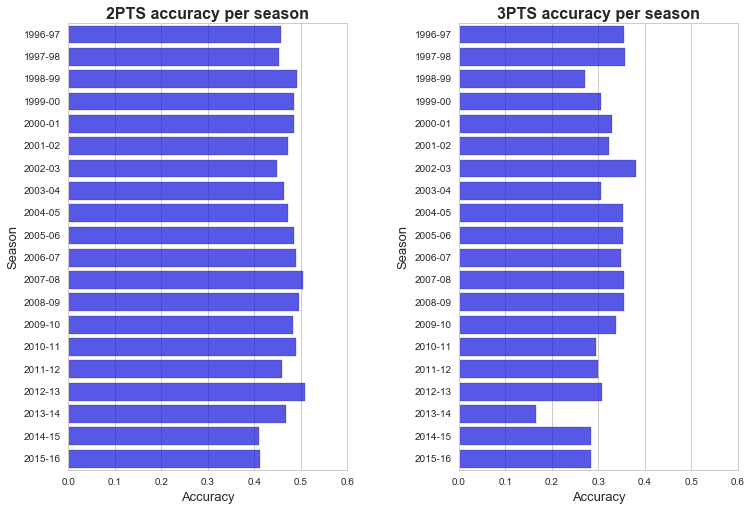

In [20]:
#Exploring the season feature
accuracySeason = data.groupby(['season', 'shot_type']
                             )['shot_made_flag'].mean().unstack().reset_index()

#plotting accuracy evolution through the years
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
f.subplots_adjust(wspace=0.4)

#Number of shots
sns.barplot(x='2PT Field Goal', y='season', data=accuracySeason, ci=None, ax=ax1, 
            color='blue', alpha=0.75)
ax1.set_title('2PTS accuracy per season', fontsize=16, fontweight='bold')
ax1.set_ylabel('Season', fontsize=13)
ax1.set_xlabel('Accuracy', fontsize=13)
ax1.set_xlim(0, 0.6)

#Accuracy
sns.barplot(x='3PT Field Goal', y='season', data=accuracySeason, ci=None, ax=ax2, 
            color='blue', alpha=0.75)
ax2.set_title('3PTS accuracy per season', fontsize=16, fontweight='bold')
ax2.set_ylabel('Season', fontsize=13)
ax2.set_xlabel('Accuracy', fontsize=13)
ax2.set_xlim(0, 0.6)

We notice that the accuracy differs accross the seasons...

In [21]:
#creating the age variable
birthdate = datetime(1978, 8, 23)
data["game_date"] = data["game_date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
data['age'] = data['game_date'].apply(lambda x: (x - birthdate).days/365.25)

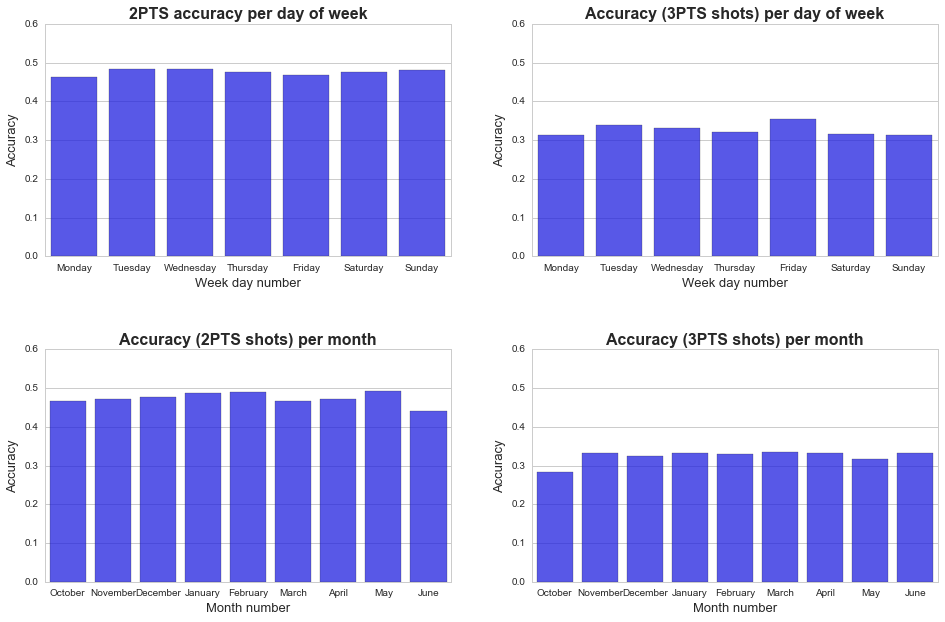

In [22]:
#Exploring the game_date feature (day of week and month)
data["week_day"] = data["game_date"].apply(lambda x: x.strftime('%A'))
data["month"] = data["game_date"].apply(lambda x: x.strftime('%B'))

accuracyDay = data.groupby(['week_day', 'shot_type']
                          )['shot_made_flag'].mean().unstack().reset_index()
accuracyMonth = data.groupby(['month', 'shot_type']
                            )['shot_made_flag'].mean().unstack().reset_index()

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(16, 10))

orderDays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='week_day', y='2PT Field Goal', data=accuracyDay, ax=ax1[0], 
            ci=None, color='blue', alpha=0.75, order=orderDays)
ax1[0].set_xlabel('Week day number', fontsize=13)
ax1[0].set_ylabel('Accuracy', fontsize=13)
ax1[0].set_title('2PTS accuracy per day of week', fontsize=16, fontweight='bold')
ax1[0].set_ylim(0, 0.6)

sns.barplot(x='week_day', y='3PT Field Goal', data=accuracyDay, ax=ax1[1], 
            ci=None, color='blue', alpha=0.75, order=orderDays)
ax1[1].set_ylim(0, 0.6)
ax1[1].set_xlabel('Week day number', fontsize=13)
ax1[1].set_ylabel('Accuracy', fontsize=13)
ax1[1].set_title('Accuracy (3PTS shots) per day of week', fontsize=16, fontweight='bold')

orderMonths = ['October', 'November', 'December', 'January', 
               'February', 'March', 'April', 'May', 'June']
sns.barplot(x='month', y='2PT Field Goal', data=accuracyMonth, ax=ax2[0], 
            ci=None, color= 'blue', alpha=0.75, order=orderMonths)
ax2[0].set_ylim(0, 0.6)
ax2[0].set_xlabel('Month number', fontsize=13)
ax2[0].set_ylabel('Accuracy', fontsize=13)
ax2[0].set_title('Accuracy (2PTS shots) per month', fontsize=16, fontweight='bold')

sns.barplot(x='month', y='3PT Field Goal', data=accuracyMonth, ax=ax2[1], 
            ci = None, color = 'blue', alpha = 0.75, order=orderMonths)
ax2[1].set_ylim(0, 0.6)
ax2[1].set_xlabel('Month number', fontsize=13)
ax2[1].set_ylabel('Accuracy', fontsize=13)
ax2[1].set_title('Accuracy (3PTS shots) per month', fontsize=16, fontweight='bold')

f.subplots_adjust(hspace=.4)

We notice that the accuracy for both 2-points and 3-points shot is a little lower on Mondays, but fairly constant the other days.
We can see that increase slowly for each month between October and February. It drops towards the end of the regular season/beginning of the playoffs (March - April) and reach a peak in may (within the playoff period).

In [23]:
#Does the fact that the game was played in Los Angeles impact accuracy?

#Determining if the game has been played in Los Angeles or not
def home(matchup):
    if 'LAL @' in matchup:
        return 0
    else:
        return 1
    
data["home_game"] = data["matchup"].apply(home)
accuracyHome = data.groupby(['home_game', 'shot_type'])['shot_made_flag'].mean().unstack()
accuracyHome

shot_type,2PT Field Goal,3PT Field Goal
home_game,,
0,0.470343,0.315480
1,0.484599,0.345115


Kobe Bryant's accuracy both for 2-points and 3-points shots is higher for games played at home than away from Los Angeles.

(0, 0.6)

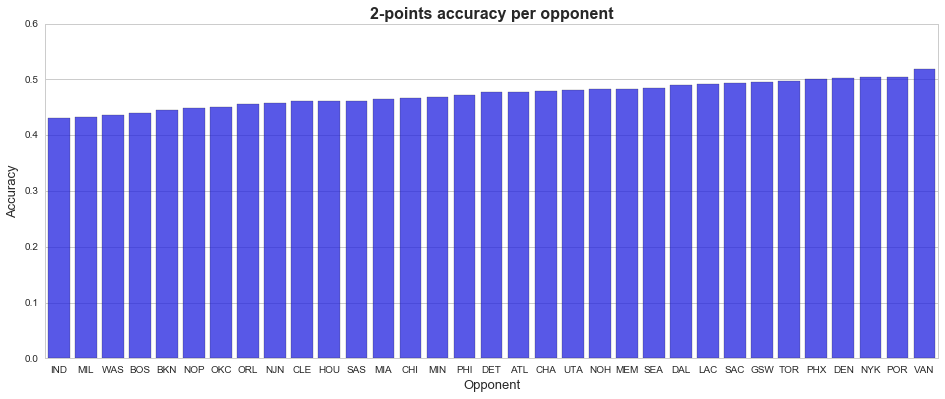

In [24]:
#Exploring the opponent feature
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

#Computing accuracy per opponent and type of shot (2 pts and 3 pts)
accuracyOpponent = data.groupby(["opponent", "shot_type"]
                               )["shot_made_flag"].mean().unstack().reset_index()

#Ploting 2 points accuracy per opponent by ascendant order
accuracyOpponent = accuracyOpponent.sort_values('2PT Field Goal')
sns.barplot(x='opponent', y='2PT Field Goal', data=accuracyOpponent, ci=None, 
            ax=ax, color='blue', alpha=0.75)
ax.set_title('2-points accuracy per opponent', fontsize=16, fontweight='bold')
ax.set_xlabel('Opponent', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_ylim(0, 0.6)

(0, 0.6)

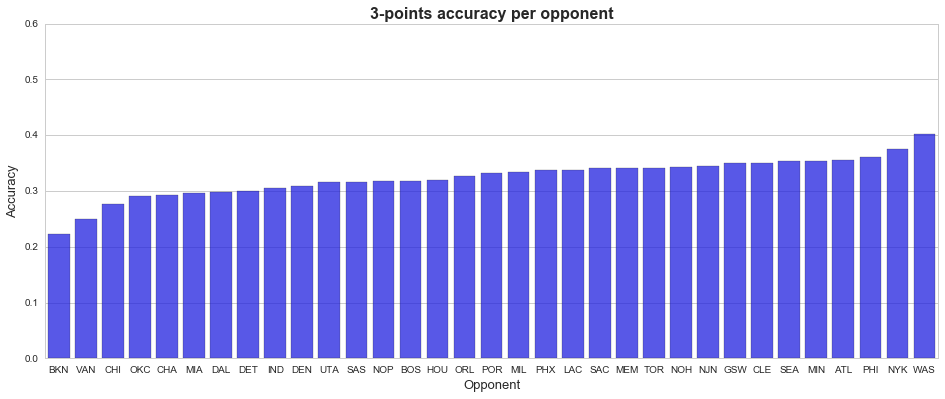

In [25]:
#Ploting 3 points accuracy per opponent by ascendant order
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
accuracyOpponent = accuracyOpponent.sort_values('3PT Field Goal')
sns.barplot(x='opponent', y='3PT Field Goal', data=accuracyOpponent, 
            ci=None, ax=ax, color='blue', alpha=0.75)
ax.set_title('3-points accuracy per opponent', fontsize=16, fontweight='bold')
ax.set_xlabel('Opponent', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_ylim(0, 0.6)

We can notice that although his 2-points accuracy against Washington (WAS) is one of the lowest among all the opponent, it is against this team that the 3-points accuracy is the highest (40%). The exact opposite can be said about the Vancouver Grizzlies team.

### 2.4 Previous games context

To help with the predictions, we will add some feature related to the previous games. It might have an influence over the future performances.

First for each game, we will compute the 2-points and 3-points accuracy from the previous game.

In [26]:
#Creating indicating columns for 2pts and 3pts attempted/made (test dataset shots excluded)
data['2pts_attempt'] = np.where((data['shot_type'] == '2PT Field Goal') 
                                & (np.isnan(data['shot_made_flag']) == False),  1, 0)
data['3pts_attempt'] = np.where((data['shot_type'] == '3PT Field Goal') 
                                & (np.isnan(data['shot_made_flag']) == False),  1, 0)
data['2pts_made'] = data['2pts_attempt'] * data['shot_made_flag']
data['3pts_made'] = data['3pts_attempt'] * data['shot_made_flag']

#Grouping per game and computing total number of made/attempted shots
games_gpe = data.groupby(['game_id', 'game_date','season', 'opponent', 'home_game'],
                         as_index=False)
games = games_gpe.agg({'2pts_attempt': 'sum',
                       '3pts_attempt': 'sum',
                       '2pts_made': 'sum',
                       '3pts_made': 'sum'
                      })

#Accuracy for the current game
games['2pts_accuracy'] = (games['2pts_made']/games['2pts_attempt'])
games['3pts_accuracy'] = (games['3pts_made']/games['3pts_attempt'])

#Shifting accuracy from 1 row
games = games.sort_values('game_date')
games['previous_count_2PT'] = games['2pts_attempt'].shift(1).fillna(0)
games['previous_count_3PT'] = games['3pts_attempt'].shift(1).fillna(0)
games['previous_accuracy_2PT'] = games['2pts_accuracy'].shift(1).fillna(0)
games['previous_accuracy_3PT'] = games['3pts_accuracy'].shift(1).fillna(0)
games.head()

,game_id,game_date,season,opponent,home_game,2pts_attempt,2pts_made,3pts_made,3pts_attempt,2pts_accuracy,3pts_accuracy,previous_count_2PT,previous_count_3PT,previous_accuracy_2PT,previous_accuracy_3PT
1079,29600027,1996-11-03,1996-97,MIN,1,1,0.0,0.0,0,0.0,NaN,0.0,0.0,0.0,0.000000
1080,29600031,1996-11-05,1996-97,NYK,0,1,0.0,0.0,0,0.0,NaN,1.0,0.0,0.0,0.000000
1081,29600044,1996-11-06,1996-97,CHA,0,1,1.0,1.0,2,1.0,0.500000,1.0,0.0,0.0,0.000000
1082,29600057,1996-11-08,1996-97,TOR,0,3,0.0,2.0,3,0.0,0.666667,1.0,2.0,1.0,0.500000
1083,29600072,1996-11-10,1996-97,ATL,1,3,0.0,0.0,0,0.0,NaN,3.0,3.0,0.0,0.666667


Then, we will add the number of rest days that Kobe got since the previous game.

In [27]:
def diff_date(actual, previous):
    d = actual - previous
    try:
        return d.days
    except AttributeError:
        return np.nan

games['previous_game_date'] = games['game_date'].shift(1)    
games['days_since_last_game'] = games.apply(lambda row : diff_date(row['game_date'], 
                                                                   row['previous_game_date']),
                                            axis=1)

Now we will add the distance in kilometers that separates the current arena to the one where the previous game occured.


In [28]:
#Import of the teams.csv file, containing for each team, the NBA division it belongs to, as 
#well as its arena's lattitude and longitude
teams = pd.read_csv("teams.csv")
teams.head()

,id_team,division,lat_arena,lon_arena
0,BOS,Atlantic,42.366303,-71.062228
1,BKN,Atlantic,40.682650,-73.974689
2,NYK,Atlantic,40.750556,-73.993611
3,PHI,Atlantic,39.901111,-75.171944
4,TOR,Atlantic,43.643333,-79.379167


In [29]:
#Merging the game and teams dataframes 
games['home_team'] = np.where(games['home_game'] == 1, 'LAL', games['opponent'])
games = pd.merge(games, teams[['id_team','division']], left_on='opponent',
                 right_on='id_team')
games = games.drop('id_team', axis = 1)
games = pd.merge(games, teams[['id_team', 'lat_arena', 'lon_arena']], 
                 left_on='home_team', right_on='id_team')
games = games.drop('id_team', axis = 1)

#Function to compute the distance between two sets of geographical coordinates
def getDistanceFromLatLonInKm(lat1, lon1, lat2, lon2):
    R = 6371
    dLat = deg2rad(lat2-lat1)
    dLon = deg2rad(lon2-lon1)
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(deg2rad(lat1)) * math.cos(deg2rad(lat2)) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d

def deg2rad(deg):
    return deg * (math.pi/180)

#Function to compute the trip distance (distance between the two consecutives arenas)
#With more than 4 days of rest, we will consider the distance between LA and the current arena
def distance_trip(row):
    if row['days_since_last_game'] < 4:
        return getDistanceFromLatLonInKm(row['lat_arena'], 
                                         row['lon_arena'], 
                                         row['previous_lat_arena'], 
                                         row['previous_lon_arena'])
    else:
        return getDistanceFromLatLonInKm(row['lat_arena'], 
                                         row['lon_arena'], 
                                         34.043056, 
                                         -118.267222)
    

#Function to compute the distance from the Staples center (Los Angeles Lakers home)    
def distance_from_staples(row):
    return getDistanceFromLatLonInKm(row['lat_arena'], 
                                     row['lon_arena'], 
                                     34.043056, 
                                     -118.267222)

#Computing trip distance and distance from Los Angeles
games['previous_lat_arena'] = games['lat_arena'].shift(1)
games['previous_lon_arena'] = games['lon_arena'].shift(1)
games['distance_trip'] = games.apply(distance_trip, axis=1)
games['distance_from_staples'] = games.apply(distance_from_staples, axis=1)

In [30]:
#Cutting the rest days into categories
bins = [0, 1, 2, 3, 4, np.inf]
labels = ['1', '2', '3', '4', '5+']
games['days_since_last_game'] = pd.cut(games['days_since_last_game'], bins, labels=labels)

Finally we compute the rank number of this game, during the season and through his career.

In [31]:
#Game number in the season
games['game_number_career'] = games['game_date'].rank()
games['game_number_season'] = games.groupby('season')['game_date'].rank()

In [32]:
#Merging the games and dataframes
games_final = games[['game_id', 'division', 'game_number_season', 'game_number_career',
                     'days_since_last_game', 'distance_trip', 'distance_from_staples', 
                     'previous_count_2PT', 'previous_count_3PT', 'previous_accuracy_2PT',
                     'previous_accuracy_3PT']]
data = pd.merge(data, games_final, on='game_id')
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id,minutes_in_game,last_minute_shot,shot_made_flag_cat,age,week_day,month,home_game,2pts_attempt,3pts_attempt,2pts_made,3pts_made,division,game_number_season,game_number_career,days_since_last_game,distance_trip,distance_from_staples,previous_count_2PT,previous_count_3PT,previous_accuracy_2PT,previous_accuracy_3PT
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,1,1,0,NaN,22.190281,Tuesday,October,0,0,0,NaN,NaN,Northwest,1.0,311.0,5+,1331.075103,1331.075103,17.0,6.0,0.235294,0.333333
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR,2,1,0,0.0,22.190281,Tuesday,October,0,1,0,0.0,0.0,Northwest,1.0,311.0,5+,1331.075103,1331.075103,17.0,6.0,0.235294,0.333333
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,3,4,0,1.0,22.190281,Tuesday,October,0,1,0,1.0,0.0,Northwest,1.0,311.0,5+,1331.075103,1331.075103,17.0,6.0,0.235294,0.333333
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,4,5,0,0.0,22.190281,Tuesday,October,0,1,0,0.0,0.0,Northwest,1.0,311.0,5+,1331.075103,1331.075103,17.0,6.0,0.235294,0.333333
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,LAL @ POR,POR,5,17,0,1.0,22.190281,Tuesday,October,0,1,0,1.0,0.0,Northwest,1.0,311.0,5+,1331.075103,1331.075103,17.0,6.0,0.235294,0.333333


### 2.5 Shot Context

We will also add some features related to what happened in the game prior to the shot. It might have an influence over the future performances.

In [33]:
#Data from the previous shot
data = data.sort_values(['game_date', 'game_event_id'])
data['last_shot'] = data.groupby('game_id')['minutes_in_game'].shift(1).fillna(0)
#minutes since the last shot
data['minutes_since_last_shot'] = data['minutes_in_game'] - data['last_shot']
#Type of the previous shot and if it was made or not
data['previous_shot_type'] = data.groupby('game_id')['shot_type'].shift(1)
data['previous_shot_made'] = data.groupby('game_id')['shot_made_flag'].shift(1)

In [34]:
#2pts and 3pts accuracy in the game prior to the shot
data['2pts_shot_attempts'] = data.groupby('game_id')['2pts_attempt'].shift(1)
data['2pts_shot_attempts'] = data.groupby('game_id')['2pts_shot_attempts'].expanding(
    min_periods=1).sum().reset_index()['2pts_shot_attempts'].fillna(0)
data['2pts_shot_made'] = data.groupby('game_id')['2pts_made'].shift(1)
data['2pts_shot_made'] = data.groupby('game_id')['2pts_shot_made'].expanding(
    min_periods=1).sum().reset_index()['2pts_shot_made'].fillna(0)
data['current_2pts_accuracy'] = (data['2pts_shot_made']/data['2pts_shot_attempts']).fillna(0)

data['3pts_shot_attempts'] = data.groupby('game_id')['3pts_attempt'].shift(1)
data['3pts_shot_attempts'] = data.groupby('game_id')['3pts_shot_attempts'].expanding(min_periods=1).sum().reset_index()['3pts_shot_attempts'].fillna(0)
data['3pts_shot_made'] = data.groupby('game_id')['3pts_made'].shift(1)
data['3pts_shot_made'] = data.groupby('game_id')['3pts_shot_made'].expanding(min_periods=1).sum().reset_index()['3pts_shot_made'].fillna(0)
data['current_3pts_accuracy'] = (data['3pts_shot_made']/data['3pts_shot_attempts']).fillna(0)
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id,minutes_in_game,last_minute_shot,shot_made_flag_cat,age,week_day,month,home_game,2pts_attempt,3pts_attempt,2pts_made,3pts_made,division,game_number_season,game_number_career,days_since_last_game,distance_trip,distance_from_staples,previous_count_2PT,previous_count_3PT,previous_accuracy_2PT,previous_accuracy_3PT,last_shot,minutes_since_last_shot,previous_shot_type,previous_shot_made,2pts_shot_attempts,2pts_shot_made,current_2pts_accuracy,3pts_shot_attempts,3pts_shot_made,current_3pts_accuracy
22901,Jump Shot,Jump Shot,102,29600027,33.9283,-140,116,-118.4098,0,1,0,1996-97,42,18,0.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1996-11-03,LAL vs. MIN,MIN,22902,11,1,0.0,18.198494,Sunday,November,1,1,0,0.0,0.0,Northwest,1.0,1.0,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,11.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
22902,Jump Shot,Jump Shot,127,29600031,33.9473,-131,97,-118.4008,10,2,0,1996-97,8,16,0.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1996-11-05,LAL @ NYK,NYK,22903,13,0,0.0,18.203970,Tuesday,November,0,1,0,0.0,0.0,Atlantic,2.0,2.0,2,1635.857213,3938.913184,1.0,0.0,0.0,0.0,0.0,13.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
22903,Jump Shot,Jump Shot,124,29600044,33.8633,-142,181,-118.4118,8,2,0,1996-97,37,23,1.0,3PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1996-11-06,LAL @ CHH,CHA,22904,15,0,1.0,18.206708,Wednesday,November,0,0,1,0.0,1.0,Southeast,3.0,3.0,1,858.174960,3406.507895,1.0,0.0,0.0,0.0,0.0,15.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
22904,Jump Shot,Jump Shot,144,29600044,34.0443,0,0,-118.2698,6,2,0,1996-97,34,0,0.0,3PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1996-11-06,LAL @ CHH,CHA,22905,17,0,0.0,18.206708,Wednesday,November,0,0,1,0.0,0.0,Southeast,3.0,3.0,1,858.174960,3406.507895,1.0,0.0,0.0,0.0,15.0,2.0,3PT Field Goal,1.0,0.0,0.0,0.0,1.0,1.0,1.0
22905,Jump Shot,Jump Shot,151,29600044,33.9063,-10,138,-118.2798,5,2,0,1996-97,27,13,1.0,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1996-11-06,LAL @ CHH,CHA,22906,18,0,1.0,18.206708,Wednesday,November,0,1,0,1.0,0.0,Southeast,3.0,3.0,1,858.174960,3406.507895,1.0,0.0,0.0,0.0,17.0,1.0,3PT Field Goal,0.0,0.0,0.0,0.0,2.0,1.0,0.5


## 3. Model and Kaggle submission

Now that we have analysed the data and perform feature engineering, we will model the shot_made_flag target variable. Since it is a categorical feature we are dealing with a classification problem.

### 3.1 Preprocessing

Before trying different models, we will first perform some preprocessing

In [35]:
#Selecting the meaningful columns for the predictions
data_train = data[['action_type', 'combined_shot_type', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'opponent', 'minutes_in_game', 'last_minute_shot', 'week_day',
       'month', 'age', 'home_game', 'division', 'game_number_season',
       'game_number_career', 'days_since_last_game', 'distance_trip',
       'distance_from_staples', 'previous_count_2PT', 'previous_count_3PT',
       'previous_accuracy_2PT', 'previous_accuracy_3PT',
       'minutes_since_last_shot', 'previous_shot_type', 'previous_shot_made',
       '2pts_shot_attempts', 'current_2pts_accuracy',
       '3pts_shot_attempts', 'current_3pts_accuracy']]

data_train.head()

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,minutes_in_game,last_minute_shot,week_day,month,age,home_game,division,game_number_season,game_number_career,days_since_last_game,distance_trip,distance_from_staples,previous_count_2PT,previous_count_3PT,previous_accuracy_2PT,previous_accuracy_3PT,minutes_since_last_shot,previous_shot_type,previous_shot_made,2pts_shot_attempts,current_2pts_accuracy,3pts_shot_attempts,current_3pts_accuracy
22901,Jump Shot,Jump Shot,33.9283,-140,116,-118.4098,0,1,0,1996-97,42,18,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,MIN,11,1,Sunday,November,18.198494,1,Northwest,1.0,1.0,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,11.0,NaN,NaN,0.0,0.0,0.0,0.0
22902,Jump Shot,Jump Shot,33.9473,-131,97,-118.4008,10,2,0,1996-97,8,16,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,NYK,13,0,Tuesday,November,18.203970,0,Atlantic,2.0,2.0,2,1635.857213,3938.913184,1.0,0.0,0.0,0.0,13.0,NaN,NaN,0.0,0.0,0.0,0.0
22903,Jump Shot,Jump Shot,33.8633,-142,181,-118.4118,8,2,0,1996-97,37,23,3PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,CHA,15,0,Wednesday,November,18.206708,0,Southeast,3.0,3.0,1,858.174960,3406.507895,1.0,0.0,0.0,0.0,15.0,NaN,NaN,0.0,0.0,0.0,0.0
22904,Jump Shot,Jump Shot,34.0443,0,0,-118.2698,6,2,0,1996-97,34,0,3PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,CHA,17,0,Wednesday,November,18.206708,0,Southeast,3.0,3.0,1,858.174960,3406.507895,1.0,0.0,0.0,0.0,2.0,3PT Field Goal,1.0,0.0,0.0,1.0,1.0
22905,Jump Shot,Jump Shot,33.9063,-10,138,-118.2798,5,2,0,1996-97,27,13,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,CHA,18,0,Wednesday,November,18.206708,0,Southeast,3.0,3.0,1,858.174960,3406.507895,1.0,0.0,0.0,0.0,1.0,3PT Field Goal,0.0,0.0,0.0,2.0,0.5


To handle the categorical features we will perform a One-Hot Encoding:

In [36]:
data_train_final = pd.get_dummies(data_train, 
                                  columns=['action_type', 'combined_shot_type', 'period',
                                           'season', 'shot_type', 'shot_zone_area', 
                                           'shot_zone_basic', 'shot_zone_range', 'opponent',
                                           'division', 'week_day', 'month', 
                                           'previous_shot_type', 'previous_shot_made', 
                                           'days_since_last_game'])

In order to avoid scaling issues in the different algorithms that we will try, we need to normalize our numerical features. The main advantage of scaling is to avoid attributes in greater numeric ranges dominating those in smaller numeric ranges.
Here, we will use a Min-Max scaling approach, to scale the features between 0 and 1.

In [37]:
#Scaling the numerical data with a min max scaler
mmScaler = MinMaxScaler()
numericalColumns = ['lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'seconds_remaining', 
                    'minutes_in_game', 'shot_distance', 'age', 'game_number_season',
                    'game_number_career', 'distance_trip', 'distance_from_staples',
                    'previous_count_2PT', 'previous_count_3PT', 'minutes_since_last_shot',
                    '2pts_shot_attempts', '3pts_shot_attempts']

data_train_final.loc[:,numericalColumns] = mmScaler.fit_transform(
    data_train_final.loc[:,numericalColumns])
data_train_final.head()

,lat,loc_x,loc_y,lon,minutes_remaining,playoffs,seconds_remaining,shot_distance,minutes_in_game,last_minute_shot,age,home_game,game_number_season,game_number_career,distance_trip,distance_from_staples,previous_count_2PT,previous_count_3PT,previous_accuracy_2PT,previous_accuracy_3PT,minutes_since_last_shot,2pts_shot_attempts,current_2pts_accuracy,3pts_shot_attempts,current_3pts_accuracy,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Cutting Finger Roll Layup Shot,action_type_Cutting Layup Shot,action_type_Driving Bank shot,action_type_Driving Dunk Shot,action_type_Driving Finger Roll Layup Shot,action_type_Driving Finger Roll Shot,action_type_Driving Floating Bank Jump Shot,action_type_Driving Floating Jump Shot,action_type_Driving Hook Shot,action_type_Driving Jump shot,action_type_Driving Layup Shot,action_type_Driving Reverse Layup Shot,action_type_Driving Slam Dunk Shot,action_type_Dunk Shot,action_type_Fadeaway Bank shot,action_type_Fadeaway Jump Shot,action_type_Finger Roll Layup Shot,action_type_Finger Roll Shot,action_type_Floating Jump shot,action_type_Follow Up Dunk Shot,action_type_Hook Bank Shot,action_type_Hook Shot,action_type_Jump Bank Shot,action_type_Jump Hook Shot,action_type_Jump Shot,action_type_Layup Shot,action_type_Pullup Bank shot,action_type_Pullup Jump shot,action_type_Putback Dunk Shot,action_type_Putback Layup Shot,action_type_Putback Slam Dunk Shot,action_type_Reverse Dunk Shot,action_type_Reverse Layup Shot,action_type_Reverse Slam Dunk Shot,action_type_Running Bank shot,action_type_Running Dunk Shot,action_type_Running Finger Roll Layup Shot,action_type_Running Finger Roll Shot,action_type_Running Hook Shot,action_type_Running Jump Shot,action_type_Running Layup Shot,action_type_Running Pull-Up Jump Shot,action_type_Running Reverse Layup Shot,action_type_Running Slam Dunk Shot,action_type_Running Tip Shot,action_type_Slam Dunk Shot,action_type_Step Back Jump shot,action_type_Tip Layup Shot,action_type_Tip Shot,action_type_Turnaround Bank shot,action_type_Turnaround Fadeaway Bank Jump Shot,action_type_Turnaround Fadeaway shot,action_type_Turnaround Finger Roll Shot,action_type_Turnaround Hook Shot,action_type_Turnaround Jump Shot,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,period_1,period_2,period_3,period_4,period_5,period_6,period_7,season_1996-97,season_1997-98,season_1998-99,season_1999-00,season_2000-01,season_2001-02,season_2002-03,season_2003-04,season_2004-05,season_2005-06,season_2006-07,season_2007-08,season_2008-09,season_2009-10,season_2010-11,season_2011-12,season_2012-13,season_2013-14,season_2014-15,season_2015-16,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),shot_zone_basic_Above the Break 3,shot_zone_basic_Backcourt,shot_zone_basic_In The Paint (Non-RA),shot_zone_basic_Left Corner 3,shot_zone_basic_Mid-Range,shot_zone_basic_Restricted Area,shot_zone_basic_Right Corner 3,shot_zone_range_16-24 ft.,shot_zone_range_24+ ft.,shot_zone_range_8-16 ft.,shot_zone_range_Back Court Shot,shot_zone_range_Less Than 8 ft.,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,division_Atlantic,division_Central,division_Northwest,division_Pacific,division_Southeast,division_Southwest,week_day_Friday,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesd

### 3.2 Trying different models

Now we have a processed dataset, we will be able to apply multiple machine learning algorithms. To evaluate them and determine which is the best, we will use the log loss criteria, as it is the one that we be used to compute the Kaggle ranking.
<br>
First we will separate the dataset in 3 parts:
- The submit set, which correspond to the observations for which we have to make a prediction in Kaggle,
- The train part (80% of the remaining observations), that will be use to train our models,
- The test set (20%) on which we will evaluate their performances.

In [38]:
#Splitting the dataset : train validation submission
submission_idx = data_train_final[np.isnan(data["shot_made_flag"])].index
train_idx = data_train_final[np.isnan(data["shot_made_flag"]) == False].index
shot_ids_submit = data.loc[submission_idx, 'shot_id'].reset_index()['shot_id']
X_submit = data_train_final.loc[submission_idx,:]
X_train, X_test, y_train, y_test = train_test_split(data_train_final.loc[train_idx,:],
                                                    data.loc[train_idx, "shot_made_flag"],
                                                    test_size=0.2, random_state=123)

We will try 5 differents models:
- Random Forest,
- Gradient Boosting,
- Logistic Regression,
- Linear Discriminant Analysis,
- Support Vector Machine.


#### 3.2.1 Random forest

We will tune the following parameters: 
- *n_estimators*: number of trees in the forest
- *criterion*: criterion that will determine the best split when building the trees (Gini Impurity or Information Gain) 
- *max_features*: number of features that will be considered in each split
- *min_samples_leaf*: mimimum sample of observation required in each tree leaf

In [39]:
param_grid_rf = {"n_estimators": [500, 750, 1000, 1500],
                 "criterion": ["gini", "entropy"],
                 "max_features": ['log2', 'sqrt', 0.25, 0.5],
                 "min_samples_leaf" : [1, 10, 20, 50]
                }

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf,
                                   scoring='log_loss', cv=3, n_jobs=6)
grid_search_rf.fit(X_train, y_train)
print('Best parameters:', grid_search_rf.best_params_)
print('CV score:', grid_search_rf.best_score_)
print('Validation score:', log_loss(y_test, grid_search_rf.predict_proba(X_test)))

Best parameters: {'max_features': 0.25, 'criterion': 'entropy', 'n_estimators': 1000, 'min_samples_leaf': 20}
CV score: -0.602329102982
Validation score: 0.605421033325


We will now have a look at the feature importance computed by the optimal model.

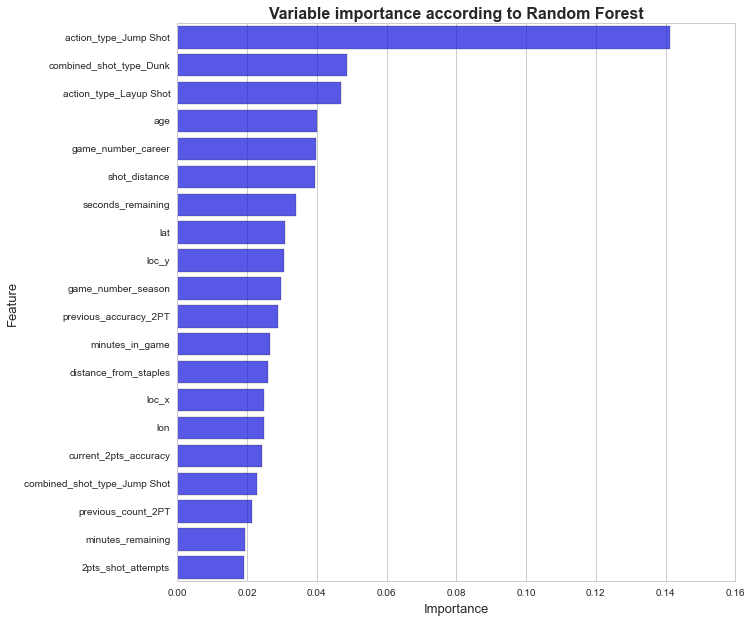

In [40]:
##Variable importance
rf_opt = RandomForestClassifier()
rf_opt.set_params(**grid_search_rf.best_params_)
rf_opt.fit(X_train, y_train)
var_importance = pd.DataFrame({'feature': X_train.columns.values,
                               'importance': rf_opt.feature_importances_
                               })

importance_top_20 = var_importance.sort_values('importance', ascending=False)[0:20]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.barplot(x='importance', y='feature', data=importance_top_20, ci=None, 
            ax=ax, color='blue', alpha=0.75)
ax.set_title('Variable importance according to Random Forest', fontsize=16, fontweight='bold')
ax.set_xlabel('Importance', fontsize=13)
ax.set_ylabel('Feature', fontsize=13)

We notice that the 3 most important features are related two the type of shot. The location and distance from where Kobe was standing as he shot is also well represented in the random forest. We can also notice that the time dimension (game_number_season, game_number_career, age) is also of importance, as well as his 2-points accuracy (in the previous game and in the game prior to the shot).

#### 3.2.2 Gradient Boosting

To find the best parameters here, we will proceed in two steps:
First we will fix the number of trees (100), and look for the best tree-specific parameters:
- *max_features*: number of features that will be considered in each split
- *max_depth*: maximum depth of each tree

Then we will determine the best number of trees (*n_estimators*) given the specific parameters that we previoulsy found.

In [41]:
#Looking for the best max_features and max_depth parameters for a given number of trees (100)
param_grid_gb = {"max_features": ['log2', 'sqrt', 0.25, 0.5],
                 "max_depth": [4, 5, 6, 7, 8]
              }

grid_search_gb = GridSearchCV(GradientBoostingClassifier(n_estimators=100), 
                              param_grid=param_grid_gb, scoring='log_loss', cv=3, 
                              n_jobs=6)

grid_search_gb.fit(X_train, y_train)
print('Best parameters:', grid_search_gb.best_params_)

Best parameters: {'max_depth': 4, 'max_features': 0.25}


In [42]:
#Looking for the optimal number of trees given the previously found parameters 
#and a learning rate
param_grid_gb_opt = {"n_estimators": [100, 250, 500, 1000]}
gb_opt = GradientBoostingClassifier(learning_rate=0.05)
gb_opt.set_params(**grid_search_gb.best_params_)
grid_search_gb_opt = GridSearchCV(gb_opt, param_grid=param_grid_gb_opt, scoring='log_loss',
                              cv=3, n_jobs=6)
grid_search_gb_opt.fit(X_train, y_train)

print('Best parameters:', grid_search_gb_opt.best_params_)
print('CV score', grid_search_gb_opt.best_score_)
print('Validation score', log_loss(y_test, grid_search_gb_opt.predict_proba(X_test)))

Best parameters: {'n_estimators': 250}
CV score -0.604933149946
Validation score 0.606699345804


#### 3.2.3 Logistic regression

For the logistic regression, we are going to tune the regularization parameters:
- *penalty*: the norm used for penalization, 
- *C*: inverse of the regularization strength.

In [43]:
param_grid_log_reg = {"C": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                      "penalty" :['l1', 'l2']}

grid_search_log_reg = GridSearchCV(LogisticRegression(), param_grid=param_grid_log_reg, 
                                   scoring = 'log_loss', cv = 3)
grid_search_log_reg.fit(X_train, y_train)

print('Best parameters:', grid_search_log_reg.best_params_)
print('CV score', grid_search_log_reg.best_score_)
print('Validation score', log_loss(y_test, grid_search_log_reg.predict_proba(X_test)))

Best parameters: {'penalty': 'l1', 'C': 0.6}
CV score -0.609545576325
Validation score 0.611484398121


#### 3.2.4 Linear Discriminant Analysis

In [44]:
param_grid_lda = {"shrinkage": [0.25, 0.5, 0.75, 'auto', None]}

grid_search_lda = GridSearchCV(LinearDiscriminantAnalysis(solver = 'lsqr'),
                               param_grid=param_grid_lda, scoring = 'log_loss', cv = 3)
grid_search_lda.fit(X_train, y_train)

print('Best parameters:', grid_search_lda.best_params_)
print('CV score', grid_search_lda.best_score_)
print('Validation score', log_loss(y_test, grid_search_lda.predict_proba(X_test)))

Best parameters: {'shrinkage': 'auto'}
CV score -0.613199974548
Validation score 0.615138860037


#### 3.2.5 SVM

In [46]:
param_grid_svm = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid']}
grid_search_svm = GridSearchCV(SVC(probability =  True), param_grid=param_grid_svm,
                               scoring = 'log_loss', cv = 3, n_jobs=6)
grid_search_svm.fit(X_train, y_train)

print('Best kernel parameter:', grid_search_svm.best_params_)
print('CV score', grid_search_svm.best_score_)
print('Validation score', log_loss(y_test, grid_search_svm.predict_proba(X_test)))

Best kernel parameter: {'kernel': 'linear'}
CV score -0.623195598177
Validation score 0.625565425518


### 3.2 Kaggle Submission

The best log-loss scores are obtain with the tuned Random Forest model. This is the one that we are going to use in order to build our Kaggle submission.

In [47]:
rf_opt.fit(data_train_final.loc[train_idx,:], data.loc[train_idx, "shot_made_flag"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.25, max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
submit = pd.DataFrame({'shot_id': shot_ids_submit, 
                       'shot_made_flag':pd.DataFrame(rf_opt.predict_proba(X_submit))[1]})
submit.to_csv('submission_rf.csv', index = False)

** This submission gives a Kaggle log-loss score of 0.59987. **